# Distributed K-Prototype Clustering with Apache Spark (local appraoch)

Distributed K-Prototype Clustering with Apache Spark" - Utilizing Spark's distributed computing, our approach partitions data into smaller chunks for parallel processing. Each partition builds a separate K-prototype clustering model, leveraging Euclidean distance for numerical and matching dissimilarity for categorical data. Predictions for data are made using a voting mechanism, aggregating results from each partition model. Finally, we transform predictions into a Spark DataFrame-compatible format

In [4]:
!pip install pyspark kmodes

In [20]:
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct
from pyspark.sql import functions as F


In [5]:

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("K=prototype local") \
    .getOrCreate()

sc = spark.sparkContext

In [6]:
df = spark.read.csv('data.csv',inferSchema=True,header=True).cache()
df.show(5)

+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|     CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|
+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+
|Female|21.0|  1.62|  64.0|                           yes|  no| 2.0|3.0|Sometimes|   no| 2.0| no|0.0|1.0|        no|Public_Transporta...|      Normal_Weight|
|Female|21.0|  1.52|  56.0|                           yes|  no| 3.0|3.0|Sometimes|  yes| 3.0|yes|3.0|0.0| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male|23.0|   1.8|  77.0|                           yes|  no| 2.0|3.0|Sometimes|   no| 2.0| no|2.0|1.0|Frequently|Public_Transporta...|      Normal_Weight|
|  Male|27.0|   1.8|  87.0|                         

In [7]:

df.select(countDistinct("NObeyesdad").alias(' cluster count')).show()

+--------------+
| cluster count|
+--------------+
|             7|
+--------------+



Removing the NObeyedsdad column

In [8]:
df_spark = df.drop(df.NObeyesdad).cache()

In [9]:

unique_counts = df_spark.agg(*(F.countDistinct(F.col(c)).alias(c) for c in df_spark.columns))

unique_counts.show()


+------+----+------+------+------------------------------+----+----+---+----+-----+----+---+----+----+----+------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|CAEC|SMOKE|CH2O|SCC| FAF| TUE|CALC|MTRANS|
+------+----+------+------+------------------------------+----+----+---+----+-----+----+---+----+----+----+------+
|     2|1402|  1574|  1525|                             2|   2| 810|635|   4|    2|1268|  2|1190|1129|   4|     5|
+------+----+------+------+------------------------------+----+----+---+----+-----+----+---+----+----+----+------+



In [10]:
df_spark.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- family_history_with_overweight: string (nullable = true)
 |-- FAVC: string (nullable = true)
 |-- FCVC: double (nullable = true)
 |-- NCP: double (nullable = true)
 |-- CAEC: string (nullable = true)
 |-- SMOKE: string (nullable = true)
 |-- CH2O: double (nullable = true)
 |-- SCC: string (nullable = true)
 |-- FAF: double (nullable = true)
 |-- TUE: double (nullable = true)
 |-- CALC: string (nullable = true)
 |-- MTRANS: string (nullable = true)



In [11]:
# seperate numerical and categorical columns

cat_columns = [col[0] for col in df_spark.dtypes if col[1] == 'string']

num_columns = [col[0] for col in df_spark.dtypes if col[1] != 'string']

cat_columns,num_columns

(['Gender',
  'family_history_with_overweight',
  'FAVC',
  'CAEC',
  'SMOKE',
  'SCC',
  'CALC',
  'MTRANS'],
 ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'])

In [12]:
for col in num_columns:
  minimum = df_spark.agg({col: "min"}).collect()[0][0]
  maximum = df_spark.agg({col: "max"}).collect()[0][0]

  df = df_spark.withColumn(col + '_norm', (df_spark[col] - minimum) / (maximum - minimum))


In [13]:
df.show(5,truncate=False)

+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+---------------------+--------+
|Gender|Age |Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|CAEC     |SMOKE|CH2O|SCC|FAF|TUE|CALC      |MTRANS               |TUE_norm|
+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+---------------------+--------+
|Female|21.0|1.62  |64.0  |yes                           |no  |2.0 |3.0|Sometimes|no   |2.0 |no |0.0|1.0|no        |Public_Transportation|0.5     |
|Female|21.0|1.52  |56.0  |yes                           |no  |3.0 |3.0|Sometimes|yes  |3.0 |yes|3.0|0.0|Sometimes |Public_Transportation|0.0     |
|Male  |23.0|1.8   |77.0  |yes                           |no  |2.0 |3.0|Sometimes|no   |2.0 |no |2.0|1.0|Frequently|Public_Transportation|0.5     |
|Male  |27.0|1.8   |87.0  |no                            |no  |3.0 |3.0|Sometimes|no   |2.0 |no |2.0|0.0|Frequen

In [14]:
from pyspark.sql.functions import col

# min_max scaling
for col_name in num_columns:
    minimum = df_spark.agg({col_name: "min"}).collect()[0][0]
    maximum = df_spark.agg({col_name: "max"}).collect()[0][0]

    df_spark = df_spark.withColumn(col_name + '_norm', (col(col_name) - minimum) / (maximum - minimum))


df_spark.show(3)


+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+-------------------+-------------------+---------+------------------+---------+------------------+--------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|     CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|           Age_norm|        Height_norm|        Weight_norm|FCVC_norm|          NCP_norm|CH2O_norm|          FAF_norm|TUE_norm|
+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+-------------------+-------------------+---------+------------------+---------+------------------+--------+
|Female|21.0|  1.62|  64.0|                           yes|  no| 2.0|3.0|Sometimes|   no| 2.0| no|0.0|1.0|        no|Public_Transporta...|0.14893617021276595|0.32075471698113234| 0.1865671641791045|      0.

In [15]:
num_columns

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [16]:
df_spark = df_spark.select([col for col in df_spark.columns if col not in num_columns])

# Show the DataFrame
df_spark.show(3)

+------+------------------------------+----+---------+-----+---+----------+--------------------+-------------------+-------------------+-------------------+---------+------------------+---------+------------------+--------+
|Gender|family_history_with_overweight|FAVC|     CAEC|SMOKE|SCC|      CALC|              MTRANS|           Age_norm|        Height_norm|        Weight_norm|FCVC_norm|          NCP_norm|CH2O_norm|          FAF_norm|TUE_norm|
+------+------------------------------+----+---------+-----+---+----------+--------------------+-------------------+-------------------+-------------------+---------+------------------+---------+------------------+--------+
|Female|                           yes|  no|Sometimes|   no| no|        no|Public_Transporta...|0.14893617021276595|0.32075471698113234| 0.1865671641791045|      0.5|0.6666666666666666|      0.5|               0.0|     0.5|
|Female|                           yes|  no|Sometimes|  yes|yes| Sometimes|Public_Transporta...|0.148936

In [17]:
num_columns = [col[0] for col in df_spark.dtypes if col[1] != 'string']
num_columns

['Age_norm',
 'Height_norm',
 'Weight_norm',
 'FCVC_norm',
 'NCP_norm',
 'CH2O_norm',
 'FAF_norm',
 'TUE_norm']

In [18]:
df_spark.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- family_history_with_overweight: string (nullable = true)
 |-- FAVC: string (nullable = true)
 |-- CAEC: string (nullable = true)
 |-- SMOKE: string (nullable = true)
 |-- SCC: string (nullable = true)
 |-- CALC: string (nullable = true)
 |-- MTRANS: string (nullable = true)
 |-- Age_norm: double (nullable = true)
 |-- Height_norm: double (nullable = true)
 |-- Weight_norm: double (nullable = true)
 |-- FCVC_norm: double (nullable = true)
 |-- NCP_norm: double (nullable = true)
 |-- CH2O_norm: double (nullable = true)
 |-- FAF_norm: double (nullable = true)
 |-- TUE_norm: double (nullable = true)



Kprototypes sequential approach

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 493, ncost: 1169.789166442324
Run: 1, iteration: 2/100, moves: 173, ncost: 1162.9746430422724
Run: 1, iteration: 3/100, moves: 72, ncost: 1161.8468400786544
Run: 1, iteration: 4/100, moves: 49, ncost: 1160.8273146224687
Run: 1, iteration: 5/100, moves: 27, ncost: 1160.5288870266947
Run: 1, iteration: 6/100, moves: 14, ncost: 1160.4678402367635
Run: 1, iteration: 7/100, moves: 11, ncost: 1160.4318843456974
Run: 1, iteration: 8/100, moves: 3, ncost: 1160.4277953629994
Run: 1, iteration: 9/100, moves: 0, ncost: 1160.4277953629994
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 590, ncost: 1160.7917507243449
Run: 2, iteration: 2/100, moves: 216, ncost: 1149.1558296838148
Run: 2, iteration: 3/100, moves: 151, ncost: 1145.3091062434332
Run: 2

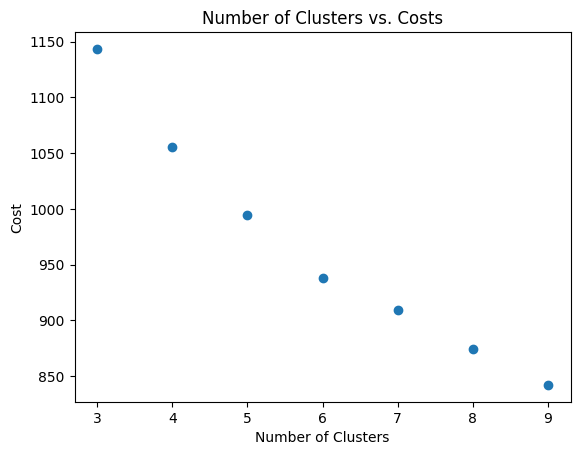

In [19]:
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
costs = []
n_clusters = []
clusters_assigned = []

cat_index = [df_spark.columns.index(col) for col in cat_columns]
for i in range(3, 10):
    try:
        kproto = KPrototypes(n_clusters=i, init='Cao', verbose=2,random_state=20)
        clusters = kproto.fit_predict(df_spark.toPandas(), categorical=cat_index)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")

plt.scatter(n_clusters, costs)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Number of Clusters vs. Costs')
plt.show()

From the plot, we could see the cost plateauing around 7 clusters

In [22]:


cat_index = [df_spark.columns.index(col) for col in cat_columns]

kproto = KPrototypes(n_clusters=7, init='Cao', verbose=2)
clusters = kproto.fit_predict(df_spark.toPandas(), categorical=cat_index)




Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 700, ncost: 969.4854450639725
Run: 1, iteration: 2/100, moves: 289, ncost: 956.6322586300153
Run: 1, iteration: 3/100, moves: 259, ncost: 936.8964360421343
Run: 1, iteration: 4/100, moves: 135, ncost: 920.8702304587785
Run: 1, iteration: 5/100, moves: 192, ncost: 914.3501981181383
Run: 1, iteration: 6/100, moves: 64, ncost: 913.5463956453316
Run: 1, iteration: 7/100, moves: 28, ncost: 913.3013733398517
Run: 1, iteration: 8/100, moves: 11, ncost: 913.2490900213306
Run: 1, iteration: 9/100, moves: 3, ncost: 913.2412085606437
Run: 1, iteration: 10/100, moves: 0, ncost: 913.2412085606437
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 936, ncost: 952.489527465665
Run: 2, iteration: 2/100, moves: 387, ncost: 937.1959802450508
Run: 2, iterati

### Local approach

We'll utilize the KPrototypes class from kmodes to parallelize the data and construct a model for each partition. Subsequently, we'll aggregate the results by employing a majority voting scheme across the clusters assigned by each model.

In [23]:
df_spark.cache()

num_partitions = df_spark.rdd.getNumPartitions()
print("Number of partitions:", num_partitions)


Number of partitions: 1


since the data is small, we can repartition manually

In [24]:
df_rdd = df_spark.rdd.repartition(3).cache()

We will use mapPartitions to partition data and send it to each worker nodes

In [25]:
all_columns = df_spark.columns
cat_index = [df_spark.columns.index(col) for col in cat_columns]

def build_model(partition_iter):
  partition_df = pd.DataFrame(partition_iter, columns=all_columns)
  kproto = KPrototypes(n_clusters=7, init='Cao', verbose=2,random_state=20)
  clusters_train = kproto.fit_predict(partition_df, categorical=cat_index)

  return [kproto]

In [26]:
models = df_rdd.mapPartitions(build_model).collect()
models

[KPrototypes(gamma=0.12010755420162897, n_clusters=7, random_state=20, verbose=2),
 KPrototypes(gamma=0.1200412483943261, n_clusters=7, random_state=20, verbose=2),
 KPrototypes(gamma=0.12084036748009028, n_clusters=7, random_state=20, verbose=2)]

since we have three partitions, we got one model for each partition

In [27]:
import numpy as np

def predict(instance):
    instance_np = np.array(instance)

    predictions = [m.predict(instance_np.reshape(1, -1), categorical=cat_index)[0] for m in models]

    return predictions

We can a perform a simple mode aggregation in this case

In [28]:
from statistics import mode

def agg_predictions(predictions):
    return mode(predictions)

clusters_pred = df_rdd.map(predict).map(agg_predictions).collect()

In [32]:
from pyspark.sql import Row
def transform(instance):

  return Row(**instance.asDict(),\
    cluster=int(agg_predictions(predict(instance))))

In [33]:
pred_df = df_rdd.map(transform).toDF()
pred_df.show(5)

+------+------------------------------+----+---------+-----+---+----------+--------------------+-------------------+-------------------+-------------------+---------+------------------+---------+------------------+--------+-------+
|Gender|family_history_with_overweight|FAVC|     CAEC|SMOKE|SCC|      CALC|              MTRANS|           Age_norm|        Height_norm|        Weight_norm|FCVC_norm|          NCP_norm|CH2O_norm|          FAF_norm|TUE_norm|cluster|
+------+------------------------------+----+---------+-----+---+----------+--------------------+-------------------+-------------------+-------------------+---------+------------------+---------+------------------+--------+-------+
|Female|                           yes|  no|Sometimes|   no| no|        no|Public_Transporta...|0.14893617021276595|0.32075471698113234| 0.1865671641791045|      0.5|0.6666666666666666|      0.5|               0.0|     0.5|      4|
|Female|                           yes|  no|Sometimes|  yes|yes| Sometim